Este notebook ejecuta los dos modelos desarrollados para la solución:
* Utilizando solo los datos de los sensores
* Utilizando los datos de los sensores y la hora actual

Para cada momento, se trata de predecir la siguiente actividad que se realizará, con los datos ya procesados en el notebook DataPrep1, donde se han creado las 3 subventanas de 30, 5 y 1 minuto. Con estos datos, se crean secuencias de 3 elementos, que sirven de entrada para la red neuronal

Es muy recomendable su ejecución en Google Colab con GPU

In [0]:
#Para cargar los datos en google colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras import initializers
from keras import optimizers

from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM

from keras import backend as K

Using TensorFlow backend.


In [0]:
#Se configura el directorio de Google Drive donde se haya guardado el resultado del script DataPrep2
WINDOW_FILE='/content/gdrive/My Drive/data1_window_next'

### Funciones para calcular las métricas Recall, Precisión y F1

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Gráficas para ver la evolución de las métricas




In [0]:
##Gráficas auxiliares para ver la evolución del accuracy y el loss
from matplotlib import pyplot as plt

def plot_acc(history, title="ACCURACY", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'],linewidth=4.0)
    ax.plot(history.history['val_acc'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Accuracy',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})
    
def plot_loss(history, title="ERROR", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'],linewidth=4.0)
    ax.plot(history.history['val_loss'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Loss',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='upper right', prop={'size': 20})
    
def plot_precision(history, title="PRECISION", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['precision_m'],linewidth=4.0)
    ax.plot(history.history['val_precision_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Precision',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})

def plot_f1(history, title="F1", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['f1_m'],linewidth=4.0)
    ax.plot(history.history['val_f1_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('F1',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})
    
def plot_recall(history, title="RECALL", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['recall_m'],linewidth=4.0)
    ax.plot(history.history['val_recall_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Recall',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})    
    
    
def plot_training(history):
    # Print learning progress
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))  
    plot_acc(history=history, ax=axs[0][0])
    plot_loss(history=history, ax=axs[0][1])
    plot_precision(history=history, ax=axs[0][2])
    plot_f1(history=history, ax=axs[1][0])
    axs[1,1].axis('off')
    plot_recall(history=history, ax=axs[1][2])
    fig.suptitle('Training Progress',fontsize=20)

## Se cargan los datos tras aplicar la ventana

In [0]:
#Como se ha utilizado una función suma para crear el df de ventana, si el sensor se ha activado varias veces a lo largo de la ventana, el número indicado será >1.
#Se modifica para que si el flag del sensor >1, quede como 1
#En caso de que no se haya activado, quedará como 0

df_win=pd.read_csv(WINDOW_FILE,delimiter='|')

#Sensores tipo flag para las 3 ventanas
columns_sens_flag=['W1D001','W1D002','W1D003','W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1M028',
         'W5D001','W5D002','W5D003','W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5M028',
         'W30D001','W30D002','W30D003','W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30M028']

#Todos los sensores para las 3 ventanas
columns_sens=['W1D001','W1D002','W1D003','W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1M028','W1T001','W1T002',
         'W5D001','W5D002','W5D003','W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5M028','W5T001','W5T002',
         'W30D001','W30D002','W30D003','W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30M028','W30T001','W30T002']

df_win[columns_sens]=df_win[columns_sens].astype(float)

dfsenses=df_win[columns_sens_flag]
#Los sensores de tipo Flag, si no son 0, se dejan a 1
dfsenses[dfsenses[columns_sens_flag] != 0.0] = 1.0


df_win[columns_sens_flag]=dfsenses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


## Output usando un One Hot encoding

In [0]:
#Se categoriza la columna actividad con un one hot encoding
df_win['next_activity'] = pd.Categorical(df_win['next_activity'])
df_output = pd.get_dummies(df_win['next_activity'])


## Input con secuencias de 3 elementos: 


*   Información de los sensores en los 30 últimos minutos
*   Información de los sensores en los 5 últimos minutos
*   Información de los sensores en el último minutos

In [0]:
sens1=['W1D001','W1D002','W1D003','W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1M028','W1T001','W1T002']
sens5=['W5D001','W5D002','W5D003','W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5M028','W5T001','W5T002']
sens30=['W30D001','W30D002','W30D003','W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30M028','W30T001','W30T002']

#Se convierte a una matriz tridimensional donde las dimensiones son: ventana, posicion en la secuencia, tiempo
a=np.asarray([df_win[sens30].values,df_win[sens5].values,df_win[sens1].values])
df_in=np.rot90(a)


## Se separan los datos en train y test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_in, df_output, test_size=0.1)

# Se crea y entrena el Modelo
Tiene las siguientes capas:
* Input
* LSTM
* Dense
* Output


In [0]:
model = Sequential()
model.add(LSTM(512, input_shape=(3, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

W0713 22:26:14.271951 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 22:26:14.319577 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 22:26:14.326716 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1118208   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1935      
Total params: 1,185,807
Trainable params: 1,185,807
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy',f1_m,precision_m, recall_m])

%time history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2, callbacks=callbacks)

W0713 22:26:28.899292 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0713 22:26:28.909439 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0713 22:26:29.097509 140465875957632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0713 22:26:29.694558 140465875957632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 308607 samples, validate on 77152 samples
Epoch 1/50
308607/308607 [==============================] - 55s 177us/step - loss: 1.8234 - acc: 0.3787 - f1_m: 0.1764 - precision_m: 0.5625 - recall_m: 0.1132 - val_loss: 1.2462 - val_acc: 0.5993 - val_f1_m: 0.4968 - val_precision_m: 0.8523 - val_recall_m: 0.3529
Epoch 2/50
308607/308607 [==============================] - 49s 160us/step - loss: 0.9400 - acc: 0.7072 - f1_m: 0.6587 - precision_m: 0.8819 - recall_m: 0.5314 - val_loss: 0.7423 - val_acc: 0.7749 - val_f1_m: 0.7517 - val_precision_m: 0.9036 - val_recall_m: 0.6451
Epoch 3/50
308607/308607 [==============================] - 48s 157us/step - loss: 0.6236 - acc: 0.8095 - f1_m: 0.7964 - precision_m: 0.9121 - recall_m: 0.7085 - val_loss: 0.5515 - val_acc: 0.8327 - val_f1_m: 0.8242 - val_precision_m: 0.9211 - val_recall_m: 0.7470
Epoch 4/50
308607/308607 [==============================] - 47s 151us/step - loss: 0.4842 - acc: 0.8512 - f1_m: 0.8464 - precision_m: 0.9260 - recall_m: 0

## Métricas de accuracy, f1, precision y recall



In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test, batch_size=64)
print("Accuracy: "+ str(accuracy))
print("F1: "+ str(f1_score))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))

42863/42863 [==============================] - 2s 54us/step
Accuracy: 0.9496302172092111
F1: 0.9516800001676969
Precision: 0.9661675100494743
Recall: 0.9378251638998302


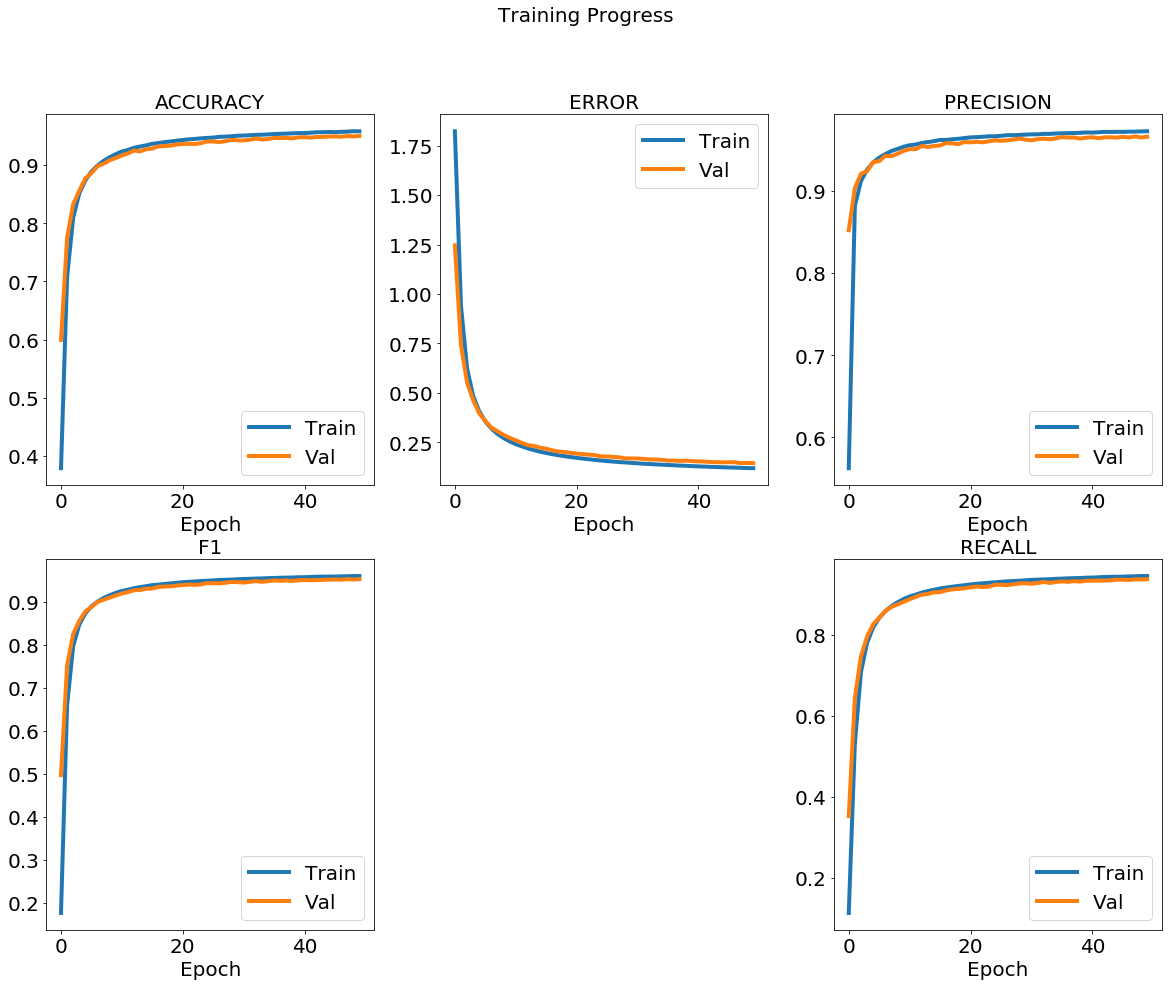

In [0]:
plot_training(history)
plt.show()

## Métricas para cada una de las categorías

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(np.asarray(y_test), axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1030
           1       0.98      0.96      0.97       526
           2       0.95      0.95      0.95      1112
           3       0.98      0.87      0.92       421
           4       0.98      0.97      0.97       734
           5       0.96      0.96      0.96      6562
           6       0.96      0.95      0.95      9141
           7       0.94      0.97      0.95      5726
           8       0.93      0.94      0.93      4551
           9       0.96      0.94      0.95      2320
          10       0.99      0.97      0.98       728
          11       0.93      0.93      0.93       564
          12       0.96      0.95      0.96      6161
          13       0.93      0.85      0.89      1034
          14       0.94      0.95      0.95      2253

    accuracy                           0.95     42863
   macro avg       0.95      0.94      0.95     42863
weighted avg       0.95   

# Modelo incluyendo la información de la hora del momento que se está analizando

In [0]:
df_win_hour=df_win
#Para cada timestamp, se extrae únicamente la hora, de 0 a 23, y se convierte en un one hot encoding
df_win_hour['now'] = pd.to_datetime(df_win_hour['now'])
df_win_hour['hour'] = df_win_hour['now'].dt.hour
df_win_hour['hour'] = pd.Categorical(df_win_hour['hour'])
df_hour = pd.get_dummies(df_win_hour['hour'],prefix = 'hour')
df_win_hour = pd.concat([df_win_hour, df_hour], axis=1)


In [0]:
df_win_hour

,Unnamed: 0,W1D001,W1D002,W1D003,W1M001,W1M002,W1M003,W1M004,W1M005,W1M006,W1M007,W1M008,W1M009,W1M010,W1M011,W1M012,W1M013,W1M014,W1M015,W1M016,W1M017,W1M018,W1M019,W1M020,W1M021,W1M022,W1M023,W1M024,W1M025,W1M026,W1M027,W1M028,W1T001,W1T002,W5D001,W5D002,W5D003,W5M001,W5M002,W5M003,...,W30M018,W30M019,W30M020,W30M021,W30M022,W30M023,W30M024,W30M025,W30M026,W30M027,W30M028,W30T001,W30T002,next_activity,now,hour,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:04.000059,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:06.000046,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:07.000064,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:08.000081,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:09.000028,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:01:13.000051,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:08:50.000081,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:08:55.000040,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:24:51.000026,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,Bed_to_Toilet,2009-10-16 00:24:57.000084,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Input con secuencias de 3 elementos: 


*   Información de los sensores en los 30 últimos minutos + hora actual
*   Información de los sensores en los 5 últimos minutos + hora actual
*   Información de los sensores en el último minutos+ hora actual



In [0]:

#Se crean secuencias de 3 elementos. 
  #Ventana de 30 minutos
  #Ventana de 5 minutos
  #Ventana de 1 minuto
sens1=['W1D001','W1D002','W1D003','W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1M028','W1T001','W1T002',
         'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
sens5=['W5D001','W5D002','W5D003','W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5M028','W5T001','W5T002',
          'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
sens30=['W30D001','W30D002','W30D003','W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30M028','W30T001','W30T002',
         'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']

a=np.asarray([df_win_hour[sens30].values,df_win_hour[sens5].values,df_win_hour[sens1].values])
df_in_hour=np.rot90(a)
df_in_hour

array([[[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_in_hour, df_output, test_size=0.1)

In [0]:
model = Sequential()
model.add(LSTM(512, input_shape=(3, 57)))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1167360   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 15)                1935      
Total params: 1,234,959
Trainable params: 1,234,959
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy',f1_m,precision_m, recall_m])

%time history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2, callbacks=callbacks)

Train on 308607 samples, validate on 77152 samples
Epoch 1/50
308607/308607 [==============================] - 49s 159us/step - loss: 1.4684 - acc: 0.5084 - f1_m: 0.3666 - precision_m: 0.6881 - recall_m: 0.2776 - val_loss: 0.7754 - val_acc: 0.7662 - val_f1_m: 0.7346 - val_precision_m: 0.8942 - val_recall_m: 0.6252
Epoch 2/50
308607/308607 [==============================] - 48s 154us/step - loss: 0.5771 - acc: 0.8222 - f1_m: 0.8094 - precision_m: 0.9054 - recall_m: 0.7341 - val_loss: 0.4540 - val_acc: 0.8591 - val_f1_m: 0.8539 - val_precision_m: 0.9158 - val_recall_m: 0.8006
Epoch 3/50
308607/308607 [==============================] - 47s 153us/step - loss: 0.3804 - acc: 0.8793 - f1_m: 0.8763 - precision_m: 0.9259 - recall_m: 0.8325 - val_loss: 0.3467 - val_acc: 0.8896 - val_f1_m: 0.8869 - val_precision_m: 0.9283 - val_recall_m: 0.8497
Epoch 4/50
308607/308607 [==============================] - 48s 154us/step - loss: 0.2998 - acc: 0.9028 - f1_m: 0.9019 - precision_m: 0.9365 - recall_m: 0

## Se evalúa el modelo, obteniendo las métricas de accuracy, f1, precision y recall

In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test, batch_size=64)
print("Accuracy: "+ str(accuracy))
print("F1: "+ str(f1_score))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))

42863/42863 [==============================] - 2s 56us/step
Accuracy: 0.9632550218220289
F1: 0.9641589465931816
Precision: 0.9695911472967257
Recall: 0.9588689545845515


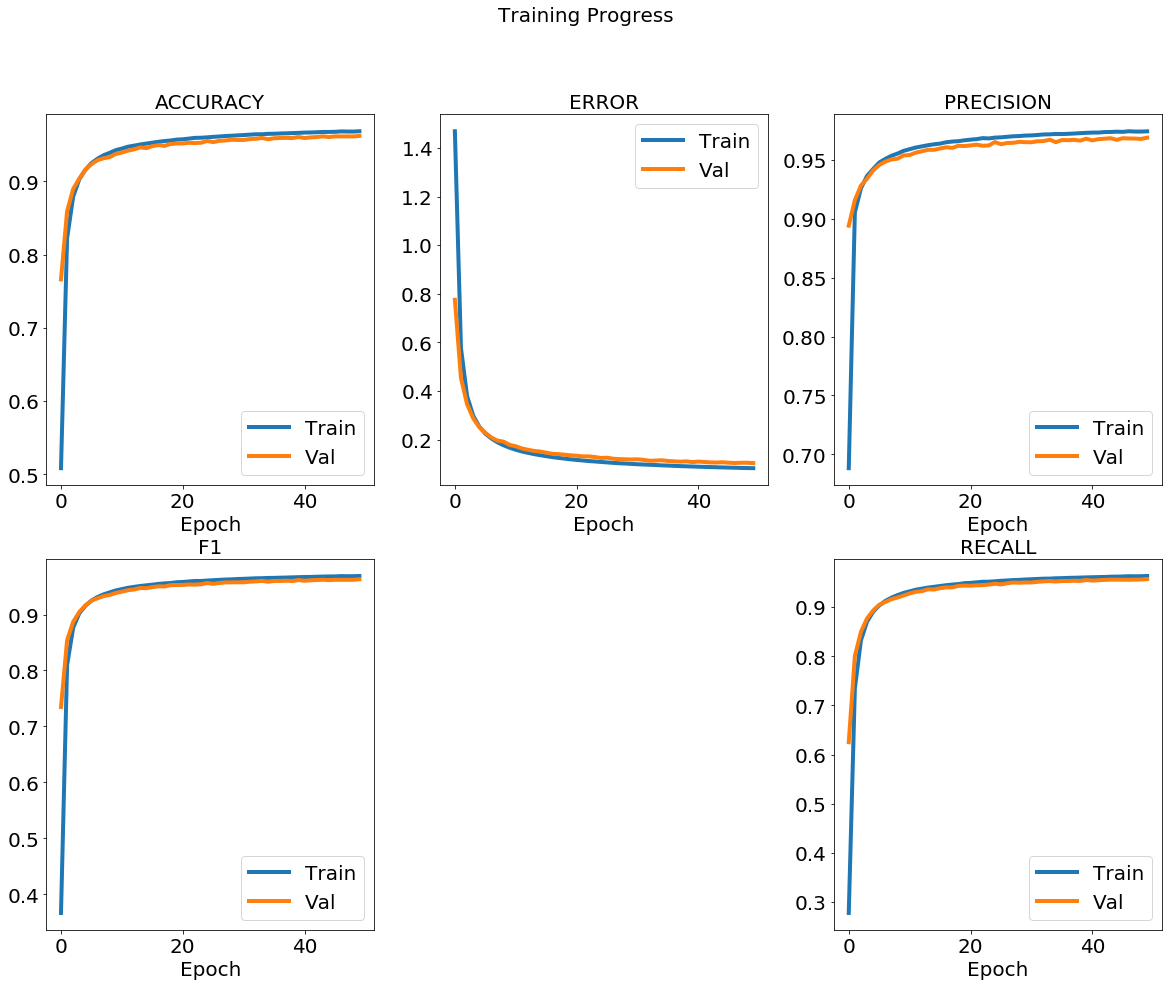

In [0]:
plot_training(history)
plt.show()

## Se obtienen las métricas para cada una de las categorías

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(np.asarray(y_test), axis=1)
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1045
           1       0.98      0.97      0.98       531
           2       0.97      0.96      0.97      1081
           3       0.97      0.88      0.92       408
           4       0.98      0.98      0.98       726
           5       0.97      0.97      0.97      6507
           6       0.97      0.96      0.96      9261
           7       0.96      0.98      0.97      5633
           8       0.96      0.95      0.96      4618
           9       0.96      0.96      0.96      2366
          10       0.99      0.98      0.99       724
          11       0.91      0.92      0.91       505
          12       0.96      0.97      0.96      6268
          13       0.93      0.89      0.91       990
          14       0.97      0.96      0.97      2200

    accuracy                           0.96     42863
   macro avg       0.96      0.95      0.96     42863
weighted avg       0.96   